## 共通処理

In [1]:
# 必要なパッケージをインポート
# NumPy用ライブラリ
import numpy as np
# Matplotlib中のpyplotライブラリのインポート
import matplotlib.pyplot as plt
# matplotlib日本語化対応ライブラリのインポート
import japanize_matplotlib
# pandas用ライブラリ
import pandas as pd
# データフレーム表示用関数
from IPython.display import display
# seaborn
import seaborn as sns
# 表示オプション調整
# NumPy表示形式の設定
np.set_printoptions(precision=3, floatmode='fixed')
# グラフのデフォルトフォント指定
plt.rcParams["font.size"] = 14
# サイズ設定
plt.rcParams['figure.figsize'] = (6, 6)
# 方眼表示ON
plt.rcParams['axes.grid'] = True
# データフレームでの表示精度
pd.options.display.float_format = '{:.3f}'.format
# データフレームですべての項目を表示
pd.set_option("display.max_columns",None)

import random

In [2]:
import pymc as pm
import arviz as az

## ch6-1: ABテストによる効果検証(目的とする指標値の違いを統計的に調べる。「Bの成功確率 - Aの成功確率」という確率変数を導入し、客観的に答える。)

問題
- 鈴木さん: Aページの表示回数40回、クリック数2回。Bページの表示回数25回、クリック数2回。
- 山田さん: Aページの表示回数1,200回、クリック数60回。Bページの表示回数1500回、クリック数110回。

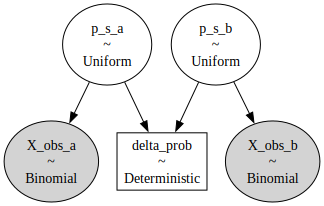

In [3]:
# 鈴木さんの方

# 表示回数とクリック数
n_a = 40
succes_a = 2
n_b = 25
succes_b = 2

# 確率モデルを定義
model = pm.Model()

with model:
    # 事前分布として一様分布を定義
    p_s_a = pm.Uniform("p_s_a", lower=0.0, upper=1.0)
    p_s_b = pm.Uniform("p_s_b", lower=0.0, upper=1.0)

    # 観測値の確率分布として二項分布を定義
    obs_a = pm.Binomial("X_obs_a", p=p_s_a, n=n_a, observed=succes_a)
    obs_b = pm.Binomial("X_obs_b", p=p_s_b, n=n_b, observed=succes_b)

    # 得られた事後分布の差を確立変数として取得
    delta_prob = pm.Deterministic("delta_prob", p_s_b - p_s_a)

g = pm.model_to_graphviz(model)
display(g)



In [4]:
# サンプリング
with model:
    idata = pm.sample(chains=2,
                      tune=1000,
                      draws=1000,
                      target_accept=0.99,
                      random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [p_s_a, p_s_b]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 17 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


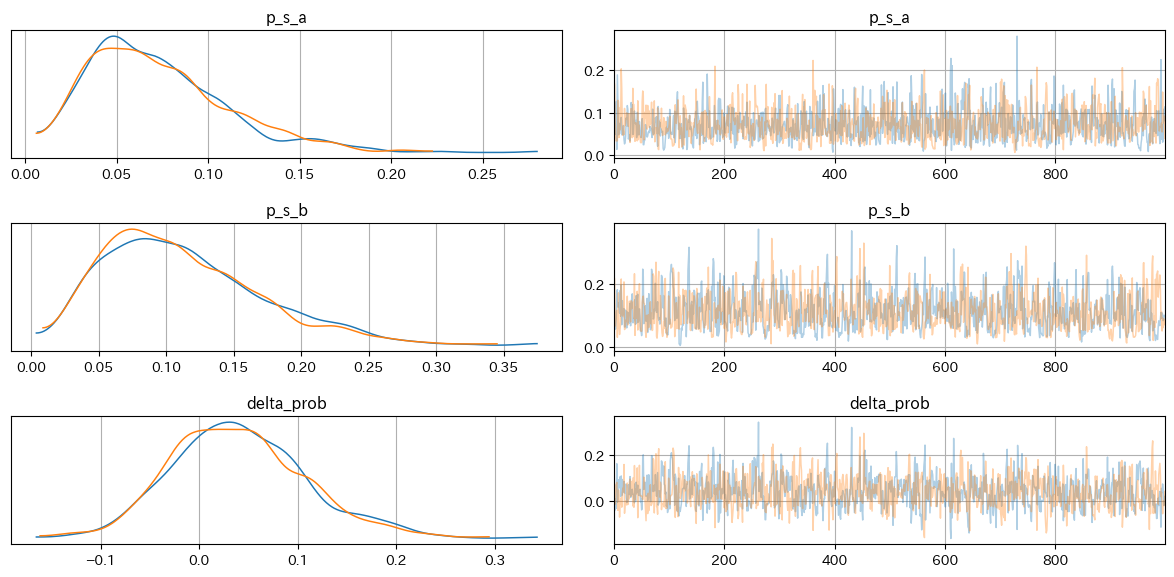

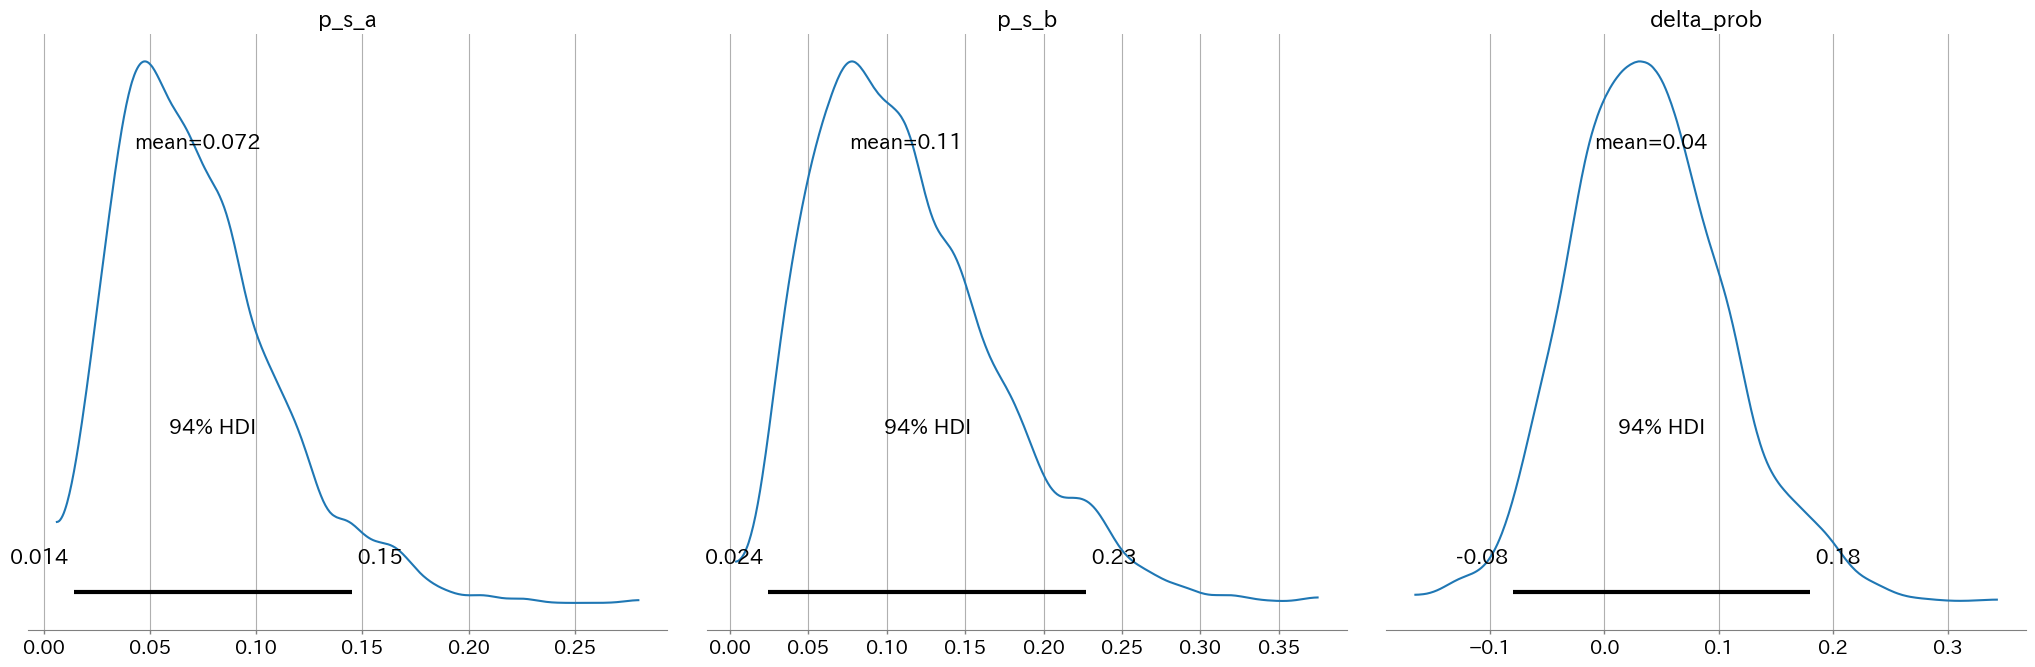

In [5]:
az.plot_trace(idata, compact=False)
plt.tight_layout();

az.plot_posterior(idata)
plt.tight_layout();

# 問題無し

<bound method _AxesBase.get_lines of <Axes: title={'center': 'delta_prob'}>>


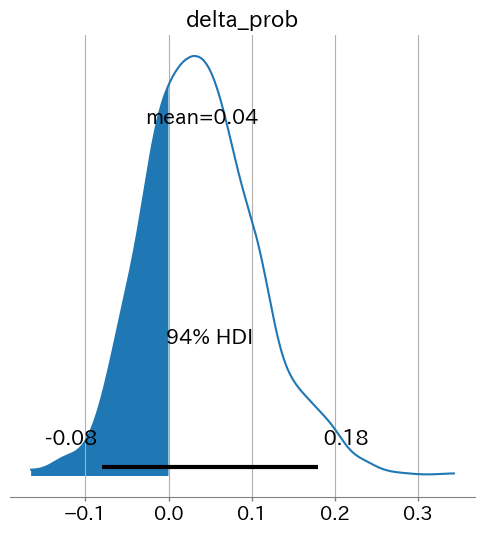

In [6]:
ax = az.plot_posterior(idata, var_names=["delta_prob"])
print(ax.get_lines)
xx, yy = ax.get_lines()[0].get_data() # 1だとHDIの両端が得られる
ax.fill_between(xx[xx<=0], yy[xx<=0]);

In [7]:
delata_prob_values = idata["posterior"].data_vars["delta_prob"].values.reshape(-1) # 2つのchainsの値を取得している

# 効果が0以下のとなったサンプルの比率
minus_sample_num = (delata_prob_values < 0).sum()
sample_num = len(delata_prob_values)
rate = minus_sample_num / sample_num * 100
print(f"{rate:.2f} %") 

29.45 %


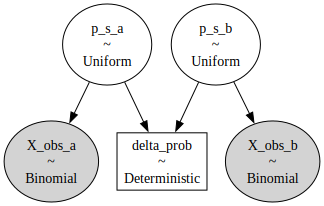

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [p_s_a, p_s_b]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 18 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


<bound method _AxesBase.get_lines of <Axes: title={'center': 'delta_prob'}>>
0.90 %


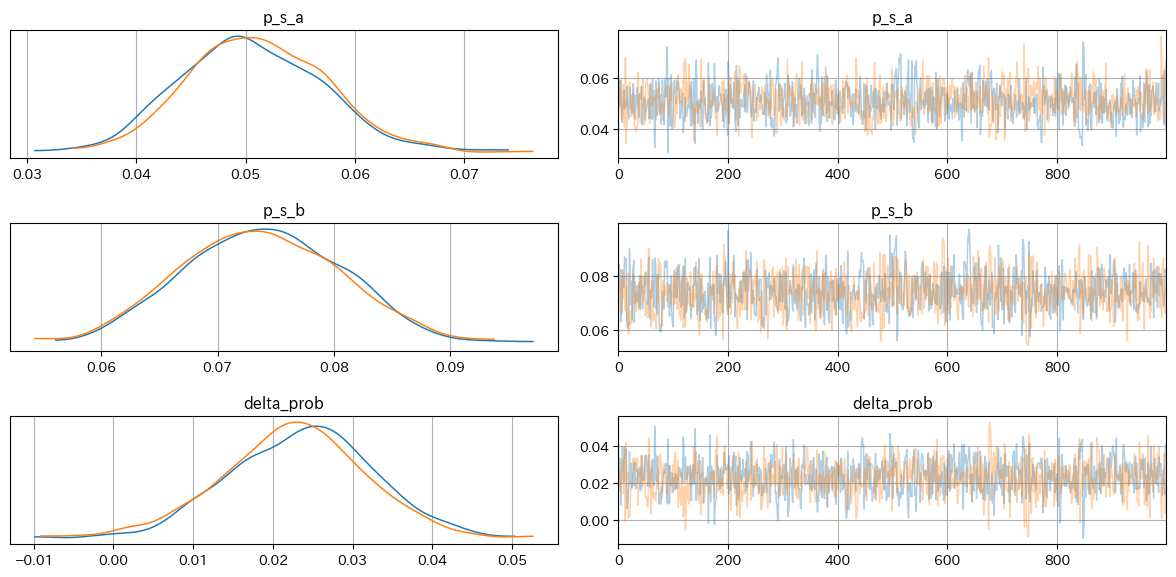

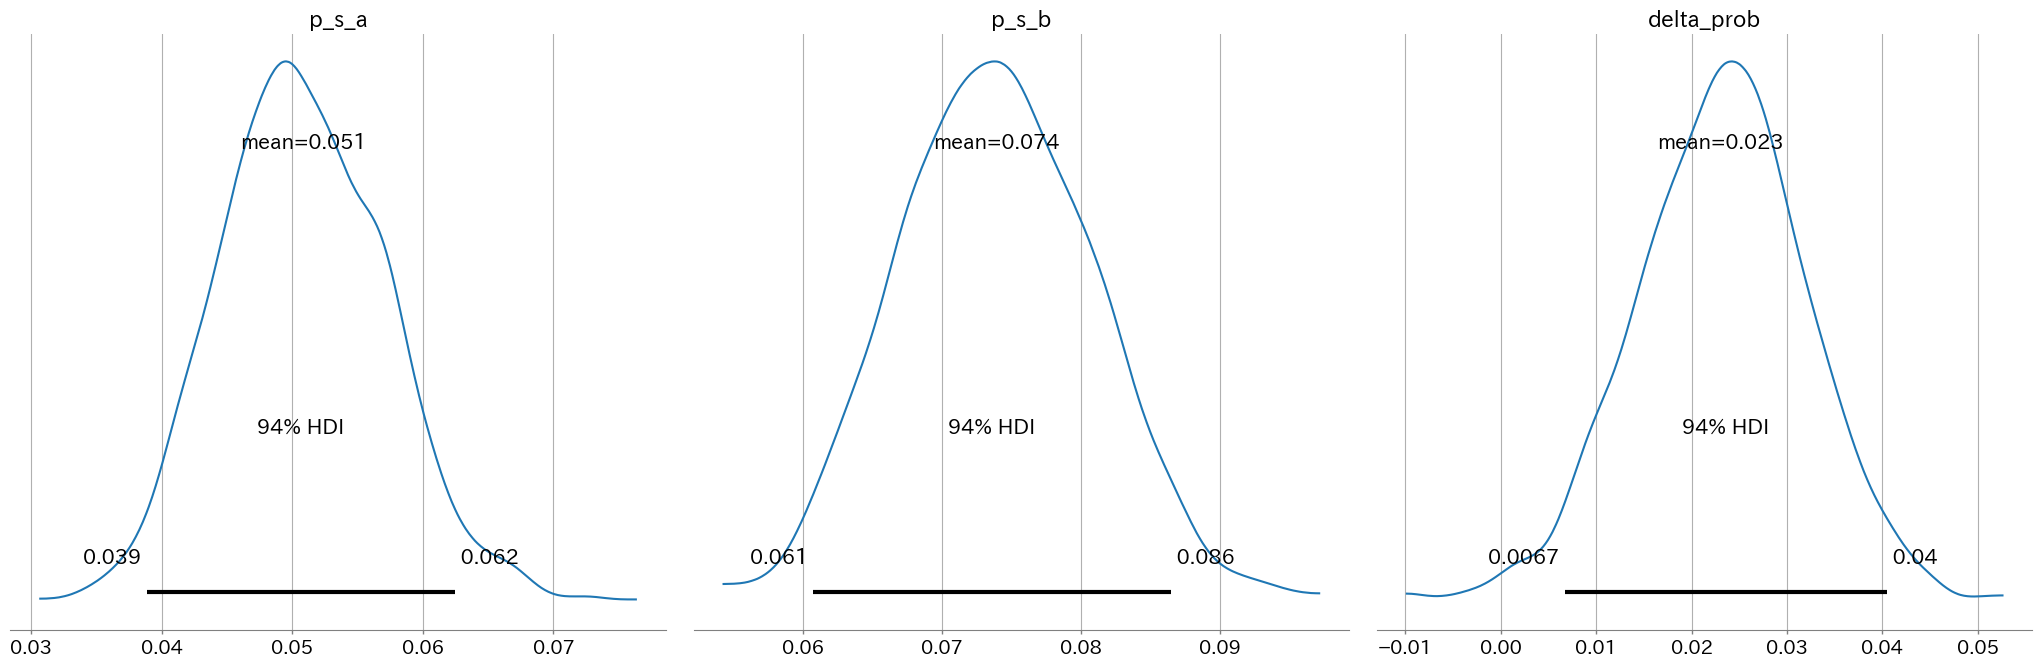

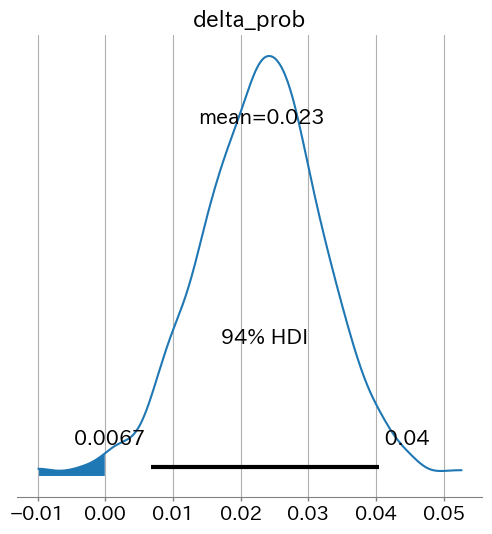

In [8]:
# 山田さんの場合

# 表示回数とクリック数
n_a = 1200
succes_a = 60
n_b = 1500
succes_b = 110

# 確率モデルを定義
model = pm.Model()

with model:
    # 事前分布として一様分布を定義
    p_s_a = pm.Uniform("p_s_a", lower=0.0, upper=1.0)
    p_s_b = pm.Uniform("p_s_b", lower=0.0, upper=1.0)

    # 観測値の確率分布として二項分布を定義
    obs_a = pm.Binomial("X_obs_a", p=p_s_a, n=n_a, observed=succes_a)
    obs_b = pm.Binomial("X_obs_b", p=p_s_b, n=n_b, observed=succes_b)

    # 得られた事後分布の差を確立変数として取得
    delta_prob = pm.Deterministic("delta_prob", p_s_b - p_s_a)

g = pm.model_to_graphviz(model)
display(g)

# サンプリング
with model:
    idata = pm.sample(chains=2,
                      tune=1000,
                      draws=1000,
                      target_accept=0.99,
                      random_seed=42)

az.plot_trace(idata, compact=False)
plt.tight_layout();

az.plot_posterior(idata)
plt.tight_layout();

ax = az.plot_posterior(idata, var_names=["delta_prob"])
print(ax.get_lines)
xx, yy = ax.get_lines()[0].get_data() # 1だとHDIの両端が得られる
ax.fill_between(xx[xx<=0], yy[xx<=0]);

delata_prob_values = idata["posterior"].data_vars["delta_prob"].values.reshape(-1) # 2つのchainsの値を取得している

# 効果が0以下のとなったサンプルの比率
minus_sample_num = (delata_prob_values < 0).sum()
sample_num = len(delata_prob_values)
rate = minus_sample_num / sample_num * 100
print(f"{rate:.2f} %") 

# 山田さんのほうが改善の確実性が高い。鈴木さんはテストを継続して、サンプルサイズを増やすべき。